### Connect To Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### ENVIROMENT SETUP

In [ ]:
# Clone repository
!git clone https://github.com/CristianTinaburri/ImageColorizationVisionAndPerception

# Copy contents
!cp -a /content/ImageColorizationVisionAndPerception/. /content/

# Clean Enviroment
!rm -rf /content/ImageColorizationVisionAndPerception
!rm -rf /content/sample_data

In [3]:
# Clean folders
!rm -rf /content/training_images
!rm -rf /content/testing_images

!mkdir /content/training_images
!mkdir /content/testing_images

In [4]:
# download datasets
!git clone https://github.com/YoongiKim/CIFAR-10-images /content/datasets/CIFAR

# Dog dataset stanford
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

!tar -xvf  'images.tar' -C '/content/datasets/'

# Stanford car dataset ( link: http://ai.stanford.edu/~jkrause/cars/car_dataset.html)
!wget http://ai.stanford.edu/~jkrause/car196/cars_train.tgz /content/datasets/
!wget http://ai.stanford.edu/~jkrause/car196/cars_test.tgz /content/datasets/

!mkdir /content/datasets/stanford_cars

!mkdir /content/datasets/stanford_cars/train
!mkdir /content/datasets/stanford_cars/test

!tar -xvf '/content/cars_train.tgz' -C '/content/datasets/stanford_cars/train'
!tar -xvf '/content/cars_test.tgz' -C '/content/datasets/stanford_cars/test'

!mv /content/datasets/stanford_cars/cars_train /content/datasets/stanford_cars/train
!mv /content/datasets/stanford_cars/cars_test /content/datasets/stanford_cars/test

Output streaming troncato alle ultime 5000 righe.
cars_test/03044.jpg
cars_test/03045.jpg
cars_test/03046.jpg
cars_test/03047.jpg
cars_test/03048.jpg
cars_test/03049.jpg
cars_test/03050.jpg
cars_test/03051.jpg
cars_test/03052.jpg
cars_test/03053.jpg
cars_test/03054.jpg
cars_test/03055.jpg
cars_test/03056.jpg
cars_test/03057.jpg
cars_test/03058.jpg
cars_test/03059.jpg
cars_test/03060.jpg
cars_test/03061.jpg
cars_test/03062.jpg
cars_test/03063.jpg
cars_test/03064.jpg
cars_test/03065.jpg
cars_test/03066.jpg
cars_test/03067.jpg
cars_test/03068.jpg
cars_test/03069.jpg
cars_test/03070.jpg
cars_test/03071.jpg
cars_test/03072.jpg
cars_test/03073.jpg
cars_test/03074.jpg
cars_test/03075.jpg
cars_test/03076.jpg
cars_test/03077.jpg
cars_test/03078.jpg
cars_test/03079.jpg
cars_test/03080.jpg
cars_test/03081.jpg
cars_test/03082.jpg
cars_test/03083.jpg
cars_test/03084.jpg
cars_test/03085.jpg
cars_test/03086.jpg
cars_test/03087.jpg
cars_test/03088.jpg
cars_test/03089.jpg
cars_test/03090.jpg
cars_test/

### LIBRARIES

In [5]:
# LIBRARIES
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np

import os
import shutil
import pandas as pd
from torchvision.io import read_image
from skimage import color

from torch.utils.data import DataLoader

import cv2

import torchvision
from torchvision import models

### Hyperparameters

In [6]:
IMG_SIZE = 32       # image size
num_epochs = 25       # number of epochs to be performed during training
batch_size = 10        # batch size
learning_rate = 1e-3      # learning rate
betas = (0.9, 0.999)      # betas
eps = 1e-08       # eps
weight_decay = 1e-5     # weight_decay

use_gpu = True          # use_gpu
num_workers = 2          # num_workers
TRANSFORM_DATA = False      # apply transform to data
TRANSFORM_DATA_MECHANICALLY = False # apply image transformation on dataset
DATASET = "CIFAR"          # the dataset you want to use for training
MODEL_PATH = "/content/gdrive/MyDrive/Computer Vision Project/Models/Resnet_18_Base" + "/"  # where to save model
MODEL_NAME = "Resnet_18_Base_model_" + DATASET     # name of model to save
NUM_EPOCH_MODEL_SAVE = 5       # how many epoch to save model
TEST_EPOCHS = 10        # the number of epoch after it need to be tested

### Image Resizing

In [7]:
directory = '/content/testing_images/'

for IMAGE_PATH in os.listdir(directory):
      if (IMAGE_PATH.endswith(".jpg")):
        print(directory + IMAGE_PATH)
        image = cv2.imread(directory + IMAGE_PATH)
        print(image.shape)

In [9]:
# Transform Images if required mechaniccally
!mkdir temp_training_images
!mkdir temp_testing_images

if TRANSFORM_DATA_MECHANICALLY == True:
  training_images = "/content/training_images/"
  testing_images = "/content/testing_images/"

  temp_training_images = "/content/temp_training_images/"
  temp_testing_images = "/content/temp_testing_images/"

  for IMAGE_PATH in os.listdir(training_images):
      if (IMAGE_PATH.endswith(".jpg")):
        print(training_images + IMAGE_PATH)
        image = cv2.imread(training_images + IMAGE_PATH)
        resized = cv2.resize(image, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(temp_training_images + IMAGE_PATH, resized)

  for IMAGE_PATH in os.listdir(testing_images):
      if (IMAGE_PATH.endswith(".jpg")):
        print(testing_images + IMAGE_PATH)
        image = cv2.imread(testing_images + IMAGE_PATH)
        resized = cv2.resize(image, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(temp_testing_images + IMAGE_PATH, resized)

!rm -rf /content/training_images/
!rm -rf /content/testing_images/

!mkdir training_images
!mkdir testing_images

!mv /content/temp_training_images/ /content/training_images/
!mv /content/temp_testing_images/ /content/testing_images/

!rm -rf /content/temp_training_images/
!rm -rf /content/temp_testing_images/

!mv /content/testing_images/temp_testing_images/* /content/testing_images/
!mv /content/training_images/temp_training_images/* /content/training_images/

!rm -rf /content/testing_images/temp_testing_images/
!rm -rf /content/training_images/temp_training_images/

Output streaming troncato alle ultime 5000 righe.
/content/testing_images/01376.jpg
/content/testing_images/04660.jpg
/content/testing_images/07012.jpg
/content/testing_images/07963.jpg
/content/testing_images/06774.jpg
/content/testing_images/02958.jpg
/content/testing_images/05464.jpg
/content/testing_images/02536.jpg
/content/testing_images/04193.jpg
/content/testing_images/06407.jpg
/content/testing_images/02211.jpg
/content/testing_images/02708.jpg
/content/testing_images/05638.jpg
/content/testing_images/03720.jpg
/content/testing_images/03434.jpg
/content/testing_images/07388.jpg
/content/testing_images/01810.jpg
/content/testing_images/03439.jpg
/content/testing_images/03649.jpg
/content/testing_images/05854.jpg
/content/testing_images/03976.jpg
/content/testing_images/02593.jpg
/content/testing_images/03962.jpg
/content/testing_images/07154.jpg
/content/testing_images/07675.jpg
/content/testing_images/03618.jpg
/content/testing_images/07597.jpg
/content/testing_images/07683.jp

### Dataset Functions

In [7]:
%cd modules

import utils

%cd ..

utils.copy_dataset_for_training('datasets/' + DATASET)
number_files_training, number_files_testing = utils.get_number_of_images()

/content/modules
/content
5000
1000


In [8]:
if TRANSFORM_DATA == True:
  transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToPILImage()])
else:
  transform = None

In [9]:
%cd modules

import dataset

# Setup data
train_set = dataset.ImageDataset("/content/training_images", transform = transform)
test_set = dataset.ImageDataset("/content/testing_images", transform = transform)

# Setup dataloaders
train_dataloader = DataLoader(train_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_set, num_workers=num_workers, batch_size=batch_size, shuffle=False)

%cd ..

/content/modules
/content


### Models

In [30]:
# THIS CELL IMPORTS THE MODELS

%cd models

import colorfulcolorization
import colornet
import colornet2
import colornetblock
import autoencoder
import ResNetBackbone18
import ResNetBackbone152
import EfficientNet

colorfulcolorization = colorfulcolorization.colorfulcolorization()
colornet1 = colornet.colornet()
colornet2 = colornet2.colornet2()
colornetblock = colornetblock.colornetblock(dim=128, percentage_dropout=0.5)
autoencoder = autoencoder.autoencoder(dimension=128, features_maps=32, percentage_dropout=0.5)
ResNetBackbone18 = ResNetBackbone18.ResNetBackbone18(p=0.8)
ResNetBackbone152 = ResNetBackbone152.ResNetBackbone152()
#EfficientNet = EfficientNet.EfficientNet()

%cd ..

/content/models
/content


In [31]:
# THIS CELLS INITIALIZE THE CHOOSEN MODEL

# Initialize model
model = ResNetBackbone18

# Initialize device
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

# Port model to device
model = model.to(device)

# Print number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

# Import libraries to get summary of model architecture
from torchvision import models
from torchsummary import summary

# Get summary of model architecture
summary(model, (1,256,256))

Number of parameters: 84002
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
           

### Training

In [32]:
# Loss function
loss_function = nn.MSELoss()
#loss_function = nn.BCELoss()
#loss_function = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
#loss_function = nn.NLLLoss()
#loss_function = nn.GaussianNLLLoss()
#loss_function = nn.CosineEmbeddingLoss()

# Optimizer 
#optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)

In [ ]:
# set to training mode
model.train()

train_loss_avg = []

print('Training Started')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    if epoch % NUM_EPOCH_MODEL_SAVE == 0 and epoch != 0:
      torch.save(model.state_dict(), MODEL_PATH + MODEL_NAME + "_" + str(int(epoch)) + ".pth")
    
    for l, ab in train_dataloader:
        
        l, ab = l.to(device), ab.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = model(l)
        
        # loss is the L2 error to the actual color (ab) components
        loss = loss_function(predicted_ab_batch, ab)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

        if num_batches*batch_size % int(number_files_training/10) == 0 and num_batches > 0:
          print(num_batches*batch_size, " / ", number_files_training)
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

torch.save(model.state_dict(), MODEL_PATH + MODEL_NAME + "_" + str(int(epoch)) + ".pth")

### Testing

In [14]:
model.eval()

test_loss_avg, num_batches = 0, 0

for l, ab in test_dataloader:

    with torch.no_grad():

        l, ab = l.to(device), ab.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = model(l)
        
        # loss is the L2 error to the actual color (ab) components
        loss = loss_function(predicted_ab_batch, ab)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 112.185143


### Plot training curves

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
# plt.plot(test_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Visualizing images

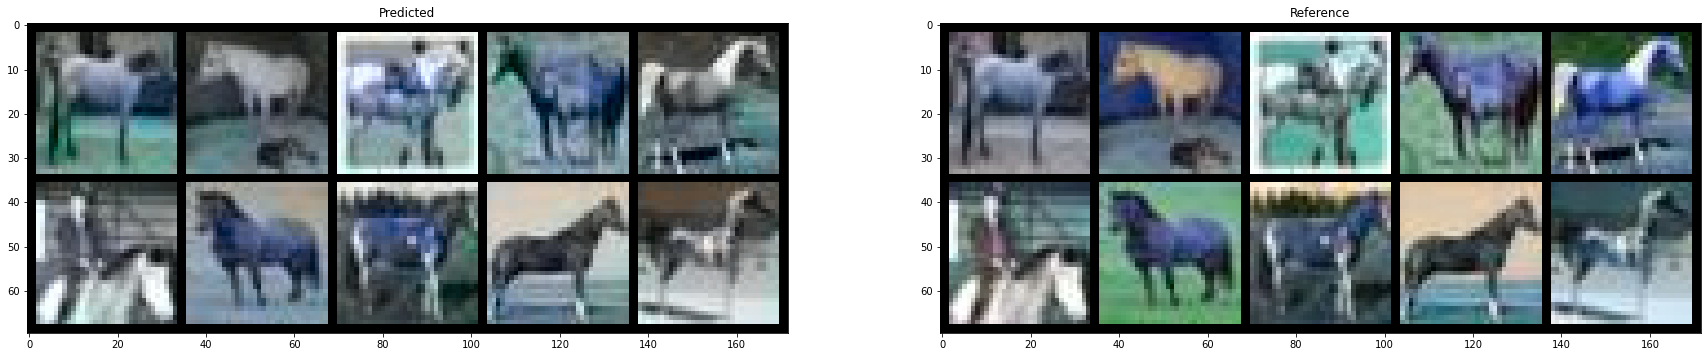

In [29]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils


number_of_images_grid = 10

with torch.no_grad():

    ######################### start mio codice #################################

    # BATCH DI TEST DI 10 IMMAGINI
    # ritorna un array con 10 numeri casuali 
    image_inds = np.random.choice(len(test_set), number_of_images_grid, replace=False)

    # ritorna un tensore cone i 10 elementi casuali
    lab_batch = torch.stack([torch.cat([test_set[i][0], test_set[i][1]], dim=0) for i in image_inds])

    # porta il lab_batch su gpu
    lab_batch = lab_batch.to(device)

    # dichiaro lista per le immagini da predirre
    predicted_lab_batch = []

    # predice il canale l dell'immagine
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], model(lab_batch[:, 0:1, :, :])], dim=1)

    # porta il batch sulla cpu
    lab_batch = lab_batch.cpu()

    # porta la batch predetta sulla cpu
    predicted_lab_batch = predicted_lab_batch.cpu()

    ########################## end mio codice ##################################

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(30, 30), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('Predicted')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('Reference')

    plt.savefig(MODEL_PATH + MODEL_NAME + '_' + str(num_epochs) + '.png', bbox_inches='tight')

    plt.show()


### Save model

In [28]:
torch.save(model.state_dict(), MODEL_NAME)

In [ ]:
model = ResNetBackbone18
model.load_state_dict("Resnet_18_Base_model_Dog_stanford_0_6.pth")
model.eval()

AttributeError: ignored